In [1]:
import sys, os
import numpy as np
sys.path.append(os.path.join(os.path.dirname('.'), '..','src'))
import seaborn as sns
import scipy.linalg
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import cv2
from utils import GP, Matern

# Set seed for reproducibility
np.random.seed(1) 

# Dataset Generation

This following notebook generates the simulated synthetic data we will use to highlight the various aspects of the coming forecasting models. As well as this we also use this notebook to simulate the various noise process which we will add to the underlying simulated data. In addition to this we use this notebook to format our real world application data set of the resultant surface displacement from a simulated earthquake and add noise to this data set also. 

## Inputs
The inputs for this notebook are the parameters for the simulation and noise models which are given in the notebook. We also have the raw binary input of the earthquake simulation model which we will use as a real world example for application of the various models. This is given by the binary files in: 

* [surf_disp_raw] - The raw binary output for the resultant surface displacement of the earthquake simulation model.


## Outputs
The outputs for this notebook are as follows. 

### Simulated experiment
* [simulated.npz] - A 100 replications of the simulated  data set designed to highlight various aspects of the work.
* [simulated_ln.npz] - A 100 replications low variance white noise to be added to the simulated data set. 
* [simulated_hn.npz] - A 100 replications high variance white noise to be added to the simulated data set. 
* [simulated_sn.npz] - A 100 replications structured noise to be added to the simulated data set.  

### Real worlds experiment
* [surf_disp.npz] - A dataset containing the output for the resultant surface displacement of the earthquake simulation model.
* [surf_disp_ln.npz] - The surface displacement data set with low variance white noise added. 
* [surf_disp_hn.npz] - The surface displacement data set with high variance white noise added. 
* [surf_disp_sn.npz] - The surface displacement data set with spatially structured noise added. 

[simulated.npz]: ../data/simulated.npz
[simulated_ln.npz]: ../data/simulated_ln.npz
[simulated_hn.npz]: ../data/simulated_hn.npz
[simulated_sn.npz]: ../data/simulated_sn.npz

[surf_disp_raw]: ../data/surf_disp_raw/
[surf_disp.npz]: ../data/surf_disp.npz
[surf_disp_ln.npz]: ../data/surf_disp_ln.npz
[surf_disp_hn.npz]: ../data/surf_disp_hn.npz
[surf_disp_sn.npz]: ../data/surf_disp_sn.npz

# Simulated Dataset

In this section we describe our simulated dataset. The domain of our simulation is the dense grid of points given by $\mathcal{S} \times \mathcal{T}$ where $\mathcal{S} \in \mathbb{R}^2$ is our spatial domain  and $\mathcal{T} \in \mathbb{R}$ is our temporal domain. In this case we take $\mathcal{S} = [-1,1] \times [-1,1]$ and $\mathcal{T} = [0,1]$. We observe a dense grid of observation in this domain with $128$ observations in both spatial dimensions and $128$ observations across the temporal domain. Effectively giving $128$ replication of functional variables in each simulation. These parameters are described below.

In [2]:
S1, S2, T = 128, 128, 128
s = np.array(np.meshgrid(np.linspace(-1,1,S1), np.linspace(-1,1,S2))).reshape(2,-1)
t = np.linspace(0,1, T)

We generate each simulation in the following manner. We first fix a number of eigenfunctions which are common across all simulations and fixed over time. We generate our time series of functional variables by allowing the contributino of each eigenfunction to vary smoothly over time. To implement this we choose the coefficients to be drawn from a gaussian process from a matern kernel with shape parameters $2.5$. We methodically decrease the variance of the gaussian process for the scores of the eigenfunctions as we increase the eigenfunction and similaily decrease the lengthscale of the process. This has the effect of giving a process which is mostly captured by the first few eigenfunctions and the contributions of the first eigenfunctions will tend to be smoother over time.  

In particular we take our eigen funcitons $\{\phi_k\}_{k=1}^{25}$ to be

$$ \phi_1(\mathbf{s}) = \mathbf{s}_1 + \sin(2 \pi \mathbf{s}_2) $$
$$ \phi_2(\mathbf{s}) = \mathbf{s}_2 + \cos(2 \pi \mathbf{s}_1) $$
$$ \phi_k(\mathbf{s}) = \sin(\frac{2}{10}\pi k \lVert \mathbf{s} \rVert ), ~k=3,\dots,25 $$

Our scores are given by:

$$ c_k(t) \sim \mathcal{GP}(0, K(t, t^\prime; \theta_k)) $$

where $\theta_k = (\sigma_k^2, l_k)$ are the hyperparameters to the matern kernel and we let $\sigma_k^2 = 0.5 e^{-\frac{k}{4}}$ and $l_k = e^{-\frac{k}{5}}$. 

We thus simulate our surface $x(\mathbf{s})_i$ for $i=1,\dots,128$ by:

$$ x_i(\mathbf{s}) = \sum_{k=1}^{25} c_k(t_i) \phi_k(\mathbf{s}) $$

We repeat such a process for each simulation. We do so for 100 simulations below.

In [3]:
# Eigenfunction generation
PHI1 = s[0] + np.sin(2*np.pi*s[1])
PHI2 = s[1] + np.cos(2*np.pi*s[0])
PHIk = np.sin(np.outer(2*np.pi*(s[0]**2 + s[1]**2), 0.1*np.arange(3, 26)))
PHI = np.hstack((PHI1[:, np.newaxis], PHI2[:, np.newaxis], PHIk))

# score generation
kern = Matern(nu=2.5, sigma=1, rho=1)
gp = GP(kern, noise_sigma=0.01)
C = np.empty((100, PHI.shape[-1], T))
for j in np.arange(100):
    for k in np.arange(25):
        gp.kernel.set_param('sigma', 1.0*np.exp(-k/2))
        gp.kernel.set_param('rho_0', np.exp(-(k/5)))
        C[j, k,:] = gp.draw(t, 1)
    
# Single simulated surface
X_sim = np.matmul(PHI, C[0]).T

We exhibit an example of a simulated surface across equal time slices and first three eigenfunctions with the corresponding coefficients in the following figures.  

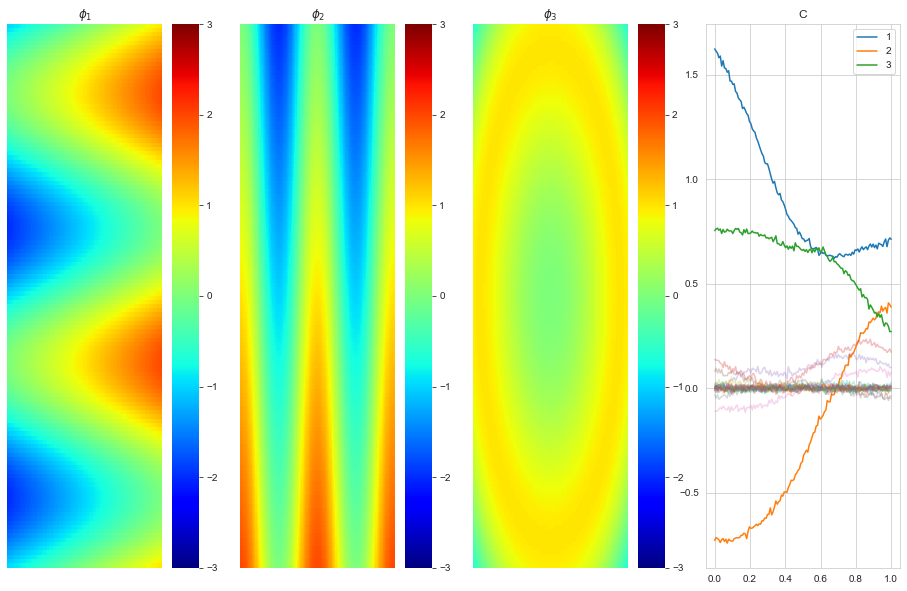

In [4]:
sns.set_style("whitegrid")
fig,axs =plt.subplots(1,4,figsize=(16,10))
for i, ax in enumerate(axs.flatten()[:3]):
    sns.heatmap(PHI[:,i].reshape(S1, S2), ax=ax, xticklabels=False, yticklabels=False, cmap='jet', vmin=-3, vmax=3)
    ax.set_title(r"$\phi_{}$".format(i+1))
ax = axs.flatten()[3]
for i, Ci in enumerate(C[0][:3]):
    sns.lineplot(x=t, y=Ci, label=(i+1))
for i, Ci in enumerate(C[0][3:]):
    sns.lineplot(x=t, y=Ci, alpha=0.3)

ax.legend()
ax.set_title("C")
plt.show()

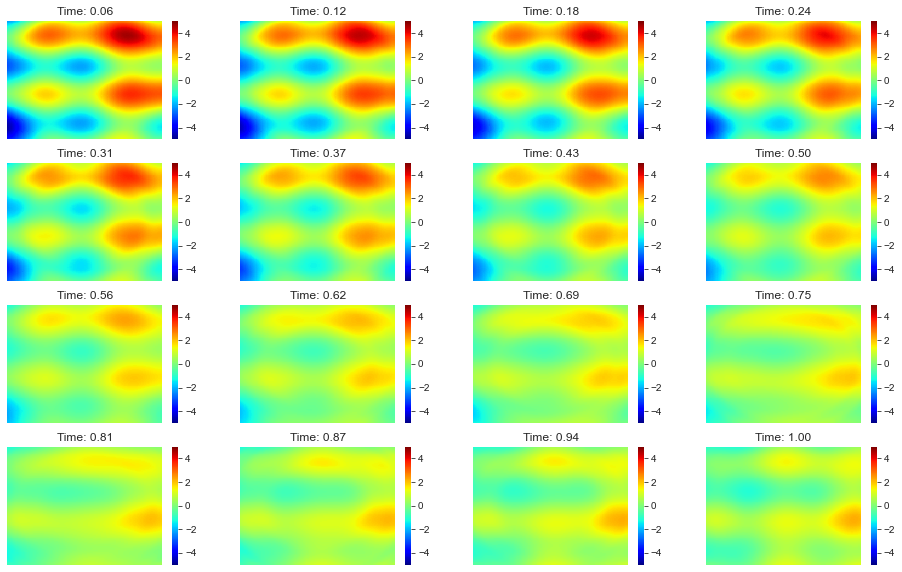

In [5]:
sns.set_style("whitegrid")
fig,axs =plt.subplots(4,4,figsize=(16,10))
N = X_sim.shape[0]//len(axs.flatten())
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(X_sim[i*N].reshape(S1, S2), ax=ax, xticklabels=False, yticklabels=False, cmap='jet', vmin=-5, vmax=5)
    ax.set_title("Time: {:.2f}".format(t[((i+1)*N) -1]))
plt.show()

We save the dataset in numpy `npz` format but we save the `PHI` matrix and `C` array instead of the simulated data for use in reconstruction. 

In [6]:
np.savez('../data/simulated.npz', PHI=PHI, C=C)

# Surface Displacement Dataset

In the following section we reformat the raw binary file for the earthquake data set into a numpy array for ease of use in the following work. The data is the resultant surface displacement from an earthquake simulation over $128$ epochs over a regular grid of size $520 \times 531$. We read all this data into a large numpy array in the following. 

In [7]:
RAW = '../data/surface_disp_raw'
IMG_SIZE = 520, 531
EPOCHS = 128
binary_files = np.sort([os.path.join(RAW, f) for f in os.listdir(RAW) if f.startswith('eq')])
SD = np.array([np.fromfile(f, dtype=np.float32) for f in binary_files])

We exhibit the surface displacement data set `SD` in the following figure. 

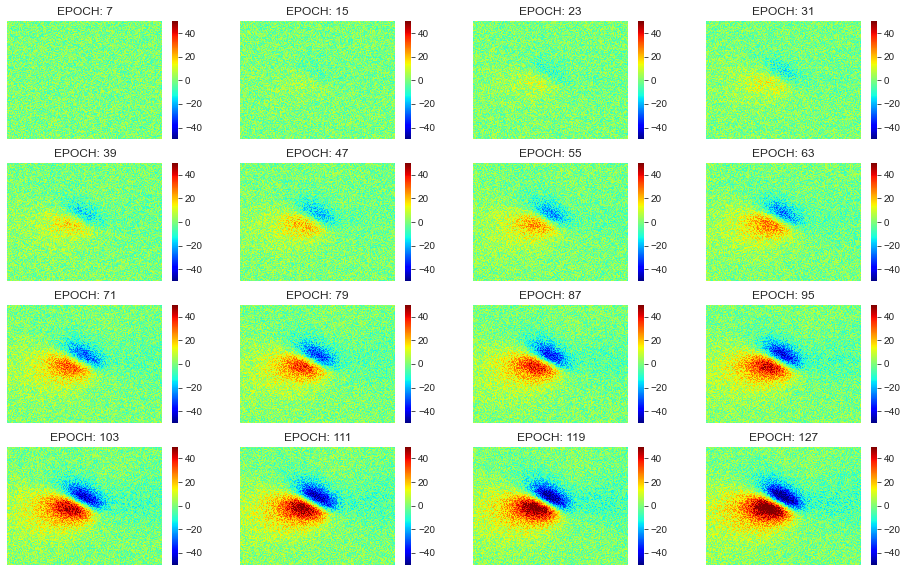

In [8]:
sns.set_style("whitegrid")
fig,axs =plt.subplots(4,4,figsize=(16,10))
N = SD.shape[0]//len(axs.flatten())
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(SD[i*N].reshape(IMG_SIZE), ax=ax, xticklabels=False, yticklabels=False, cmap='jet', vmin=-50, vmax = 50)
    ax.set_title("EPOCH: {:d}".format(np.arange(EPOCHS)[((i+1)*N) -1]))
plt.show()

We save the dataset in numpy `npz` format in the below. 

In [9]:
np.savez('../data/surf_disp.npz', SD=SD)

# Noise Generation

To all the above datasets we generate three forms of noise to add to them to see the impact of such noise on our forecasting models. In particular we use:

* Low unstructured noise - Gaussian noise with low variance which is independent in both space and time. 
* High unstructured noise - Gaussian noise with high variance which is independent in both space and time. 
* Structured noise - Gaussian noise which is dependent in space but independent in time we use a gaussian process with an isotropic matern kernel with lengthscale $l$ and shape parameter fixed to $1.5$. 

We develop a function for each which takes in variance parameter and size of dataset to generate them. 

In [10]:
def whiteNoise(var, ds_size):
    return np.random.normal(0, var, ds_size)

def structNoise(var, ds_size, l=0.2, scale_percent=20):
    kernel = Matern(nu=1.5, sigma=np.sqrt(var), rho=[l,l])
    n = ds_size[0]
    width = int(ds_size[2] * scale_percent / 100)
    height = int(ds_size[1] * scale_percent / 100)
    s =  np.array(np.meshgrid(np.linspace(0,1,height), np.linspace(0,1,width))).reshape(2,-1).T 
    gp = GP(kernel)
    sn = gp.draw(s, n).reshape(n, width, height)
    output = np.array([cv2.resize(sni, (ds_size[2], ds_size[1]), interpolation = cv2.INTER_CUBIC) for sni in sn]).reshape(n, -1)
    return output


Using the `whiteNoise` function we can simulate the unstructured noise for both datasets. Similarily using the `structNoise` function we can simulate structured noise. We do this in the following code blocks. We also save the full dataset and display an example of each in the following figures. We simulate a noise process for each of our 100 simulations for our experimental datasets that we have made above. 

### Simulated Data

In [11]:
X_sim_ln = np.array([whiteNoise(0.2, X_sim.shape) for j in np.arange(100)])
X_sim_hn = np.array([whiteNoise(1.0, X_sim.shape) for j in np.arange(100)])
X_sim_sn = np.array([structNoise(0.3, (X_sim.shape[0], S1, S2), scale_percent=25, l=0.2**2) for j in np.arange(100)])

Examples of the noisy data set is give in the following figure.

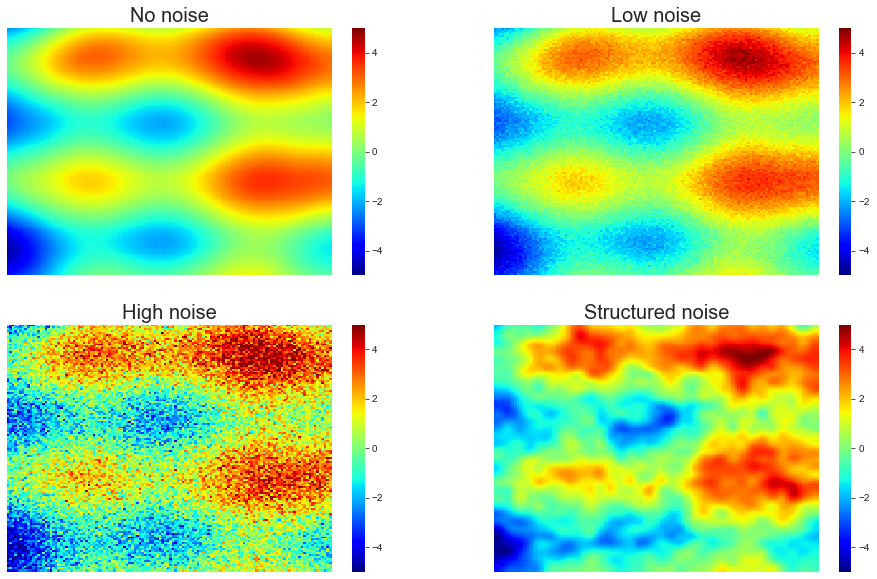

In [12]:
sns.set_style("whitegrid")
i = np.random.randint(X_sim.shape[0])
fig,axs =plt.subplots(2,2,figsize=(16,10))
for ax, X, X_lab in zip(axs.flatten(),[X_sim,
                                       X_sim + X_sim_ln[0],
                                       X_sim + X_sim_hn[0],
                                       X_sim + X_sim_sn[0]], ['No noise', 'Low noise', 'High noise','Structured noise']):
    sns.heatmap(X[i].reshape(S1,S2), ax=ax, xticklabels=False, yticklabels=False, cmap='jet', vmin=-5, vmax = 5)
    ax.set_title(X_lab, fontsize=20)
plt.show()

Below we save the simulated dataset with noise.

In [13]:
np.savez('../data/simulated_ln.npz', sim=X_sim_ln)
np.savez('../data/simulated_hn.npz', sim=X_sim_hn)
np.savez('../data/simulated_sn.npz', sim=X_sim_sn)

### Surface Displacement

In [14]:
SD_ln = whiteNoise(5.0, SD.shape)
SD_hn = whiteNoise(20.0, SD.shape)
SD_sn = structNoise(20.0, (SD.shape[0], *IMG_SIZE), scale_percent=10, l=0.3**2)

Examples of the noisy data set is give in the following figure.

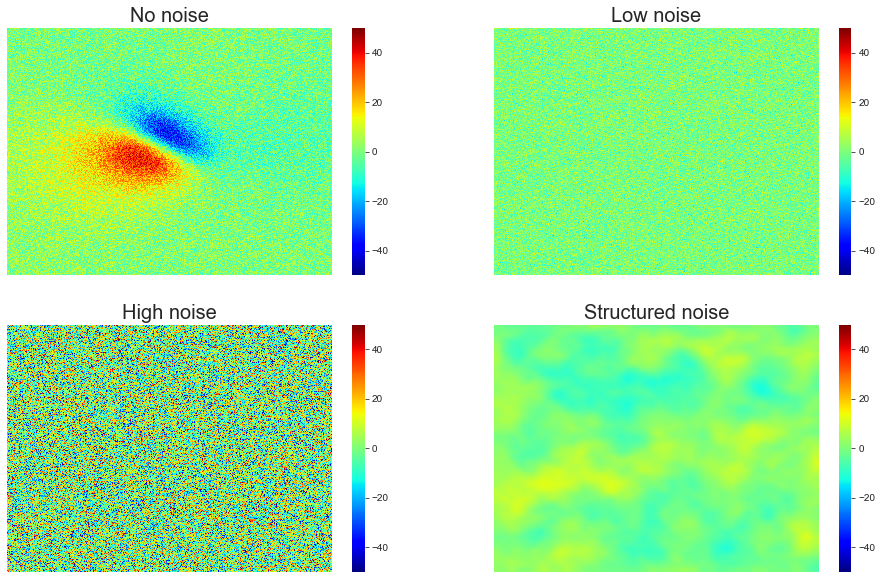

In [15]:
sns.set_style("whitegrid")
i = np.random.randint(SD.shape[0])
fig,axs =plt.subplots(2,2,figsize=(16,10))
for ax, X, X_lab in zip(axs.flatten(),[SD, SD_ln, SD_hn, SD_sn], ['No noise', 'Low noise', 'High noise','Structured noise']):
    sns.heatmap(X[i].reshape(*IMG_SIZE), ax=ax, xticklabels=False, yticklabels=False, cmap='jet', vmin=-50, vmax = 50)
    ax.set_title(X_lab, fontsize=20)
plt.show()

Below we save these data sets. 

In [16]:
np.savez('../data/surf_disp_ln.npz', SD_ln=SD_ln)
np.savez('../data/surf_disp_hn.npz', SD_hn=SD_hn)
np.savez('../data/surf_disp_sn.npz', SD_sn=SD_sn)

In the above notebook we have simulated 100 replications of an experimental data set, and formatted our real world example of surface displacements from an simulated earthquake, `SD`. We have added noise of varying types via the `whiteNoise` and `structNoise` functions. We have saved these results in `.npz` format to be loaded efficiently in future workflows. 